In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow import keras
from math import sqrt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import csv

/home/kchen/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/kchen/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
data = pd.read_csv('data/train_10_os.csv')

y = data['3-yr Mortality']
X = data.drop(['3-yr Mortality'], axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=1)



In [3]:
models = ['rf', 'xgb', 'keras']
hp_dfs = {}
for model in models:
    hp_dfs[model] = pd.read_csv('hp_search/results/results_' + model + '.csv')

In [4]:
hp_dfs['xgb'].head()

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,64,0.595551,0.015602,0.022863,0.000601,0.6,0.03,6,2,200,0.6,"OrderedDict([('colsample_bytree', 0.6), ('lear...",0.798183,0.794379,0.768539,0.784222,0.823207,0.793706,0.017967,1
1,63,0.606801,0.006848,0.024852,0.002702,0.6,0.03,6,2,200,0.6,"OrderedDict([('colsample_bytree', 0.6), ('lear...",0.798183,0.794379,0.768539,0.784222,0.823207,0.793706,0.017967,1
2,62,0.602265,0.004878,0.024982,0.002581,0.6,0.03,6,2,200,0.6,"OrderedDict([('colsample_bytree', 0.6), ('lear...",0.798183,0.794379,0.768539,0.784222,0.823207,0.793706,0.017967,1
3,80,0.607489,0.006998,0.023969,0.001186,0.6,0.03,6,2,200,0.6,"OrderedDict([('colsample_bytree', 0.6), ('lear...",0.798183,0.794379,0.768539,0.784222,0.823207,0.793706,0.017967,1
4,68,0.671840,0.008621,0.023959,0.001621,0.8,0.03,6,2,200,0.6,"OrderedDict([('colsample_bytree', 0.8), ('lear...",0.792047,0.797938,0.769193,0.786480,0.818688,0.792869,0.016090,5


In [5]:
rf_params = hp_dfs['rf']['params'].iloc[0]

In [6]:
rf_params

"OrderedDict([('bootstrap', True), ('max_depth', 120), ('max_features', 'auto'), ('min_samples_leaf', 8), ('min_samples_split', 3), ('n_estimators', 750)])"

In [7]:
rf_params = {'bootstrap': hp_dfs['rf']['param_bootstrap'].iloc[0],
            'max_depth': hp_dfs['rf']['param_max_depth'].iloc[0],
            'max_features': hp_dfs['rf']['param_max_features'].iloc[0],
            'min_samples_leaf': hp_dfs['rf']['param_min_samples_leaf'].iloc[0],
            'min_samples_split': hp_dfs['rf']['param_min_samples_split'].iloc[0],
            'n_estimators': hp_dfs['rf']['param_n_estimators'].iloc[0]}
#change nan to None
rf_params = {k: None if pd.isna(v) else v for k, v in rf_params.items()}
best_rf = RandomForestClassifier(**rf_params)
best_rf.fit(X, y)

RandomForestClassifier(max_depth=120.0, min_samples_leaf=8, min_samples_split=3,
                       n_estimators=750)

In [8]:
xgb_params = {'colsample_bytree': hp_dfs['xgb']['param_colsample_bytree'].iloc[0],
            'learning_rate': hp_dfs['xgb']['param_learning_rate'].iloc[0],
            'max_depth': hp_dfs['xgb']['param_max_depth'].iloc[0],
            'min_child_weight': hp_dfs['xgb']['param_min_child_weight'].iloc[0],
            'n_estimators': hp_dfs['xgb']['param_n_estimators'].iloc[0],
            'subsample': hp_dfs['xgb']['param_subsample'].iloc[0]}
best_xgb = XGBClassifier(**xgb_params)  
best_xgb.fit(X, y)

/home/kchen/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:20:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.03, max_delta_step=0, max_depth=6,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=32, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.6, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [9]:
keras_params = {'n_hidden': hp_dfs['keras']['param_n_hidden'].iloc[0],
            'n_neurons': hp_dfs['keras']['param_n_neurons'].iloc[0],
            'learning_rate': hp_dfs['keras']['param_learning_rate'].iloc[0],
            'dropout': hp_dfs['keras']['param_dropout'].iloc[0],
            'activation': hp_dfs['keras']['param_activation'].iloc[0]}

input_shape = [X_train.shape[1]]

def build_model(n_hidden=1, n_neurons=100, dropout=0.4, activation = "relu", learning_rate=3e-3):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=input_shape))
    model.add(keras.layers.BatchNormalization())
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dropout(dropout))
        model.add(keras.layers.Activation(activation))
    model.add(keras.layers.Dense(1, activation="sigmoid"))

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(loss="binary_crossentropy", metrics=['AUC'], optimizer=optimizer)
    return model

best_keras = keras.wrappers.scikit_learn.KerasClassifier(build_fn = lambda: 
            build_model(n_hidden=keras_params['n_hidden'],
                        n_neurons=keras_params['n_neurons'],
                        dropout=keras_params['dropout'],
                        activation=keras_params['activation'],
                        learning_rate=keras_params['learning_rate']))

early_stopping = keras.callbacks.EarlyStopping(
    patience=15,
    min_delta=1e-8,
    restore_best_weights=True,)

best_keras.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[early_stopping])

/tmp/ipykernel_398993/847982645.py:25: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  best_keras = keras.wrappers.scikit_learn.KerasClassifier(build_fn = lambda:
2022-12-22 19:20:49.087007: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-22 19:20:50.541076: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18294 MB memory:  -> device: 0, name: NVIDIA RTX A4500, pci bus id: 0000:81:00.0, compute capability: 8.6
2022-12-22 19:20:50.541722: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10368 MB memory:  -> d

Epoch 1/100
 28/277 [==>...........................] - ETA: 1s - loss: 0.7094 - auc: 0.6420 

2022-12-22 19:20:53.340448: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


277/277 [==============================] - 5s 9ms/step - loss: 0.5718 - auc: 0.6524 - val_loss: 0.4668 - val_auc: 0.7366
Epoch 2/100
277/277 [==============================] - 2s 7ms/step - loss: 0.5159 - auc: 0.6928 - val_loss: 0.4996 - val_auc: 0.7257
Epoch 3/100
277/277 [==============================] - 2s 7ms/step - loss: 0.5063 - auc: 0.7005 - val_loss: 0.4553 - val_auc: 0.7499
Epoch 4/100
277/277 [==============================] - 2s 8ms/step - loss: 0.4855 - auc: 0.7177 - val_loss: 0.4792 - val_auc: 0.7387
Epoch 5/100
277/277 [==============================] - 2s 8ms/step - loss: 0.4844 - auc: 0.7179 - val_loss: 0.4593 - val_auc: 0.7558
Epoch 6/100
277/277 [==============================] - 2s 8ms/step - loss: 0.4707 - auc: 0.7301 - val_loss: 0.4654 - val_auc: 0.7538
Epoch 7/100
277/277 [==============================] - 2s 8ms/step - loss: 0.4688 - auc: 0.7318 - val_loss: 0.4572 - val_auc: 0.7565
Epoch 8/100
277/277 [==============================] - 2s 8ms/step - loss: 0.4638

In [10]:
def roc_auc_ci(y_true, y_score, positive=1):
    AUC = roc_auc_score(y_true, y_score)
    N1 = sum(y_true == positive)
    N2 = sum(y_true != positive)
    Q1 = AUC / (2 - AUC)
    Q2 = 2*AUC**2 / (1 + AUC)
    SE_AUC = sqrt((AUC*(1 - AUC) + (N1 - 1)*(Q1 - AUC**2) + (N2 - 1)*(Q2 - AUC**2)) / (N1*N2))
    lower = AUC - 1.96*SE_AUC
    upper = AUC + 1.96*SE_AUC
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    return (lower, AUC, upper)

def roc_prc_ci(y_true, y_score, positive=1):
    AUC = average_precision_score(y_true, y_score)
    N1 = sum(y_true == positive)
    N2 = sum(y_true != positive)
    Q1 = AUC / (2 - AUC)
    Q2 = 2*AUC**2 / (1 + AUC)
    SE_AUC = sqrt((AUC*(1 - AUC) + (N1 - 1)*(Q1 - AUC**2) + (N2 - 1)*(Q2 - AUC**2)) / (N1*N2))
    lower = AUC - 1.96*SE_AUC
    upper = AUC + 1.96*SE_AUC
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    return (lower, AUC, upper)

def auroc_ci(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    mean = roc_auc
    std = sqrt(roc_auc * (1.0 - roc_auc) / len(y_true))
    low  = mean - std
    high = mean + std
    return low, mean, high
#calculate auprc 95% ci for each model
def auprc_ci(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)
    mean = pr_auc
    std = sqrt(pr_auc * (1.0 - pr_auc) / len(y_true))
    low  = mean - std
    high = mean + std
    return low, mean, high


In [11]:
lr = LogisticRegression(penalty='none', max_iter=9999)

lr.fit(X, y)

LogisticRegression(max_iter=9999, penalty='none')

In [12]:
test = pd.read_csv('data/test_17_os.csv')

y_test = test['3-yr Mortality']
X_test = test.drop('3-yr Mortality', axis=1)

#tnm_stage is the 'T' + t stage + 'N' + n stage
data['tnm_stage'] = 'T' + data['T Stage'].astype(str) + 'N' + data['N Stage'].astype(str)
data['tnm_stage'].value_counts()
#get the 3-yr Mortality rate for each tnm stage
avg_mort = data.groupby('tnm_stage')['3-yr Mortality'].mean()
#for the test set, replace the tnm stage with the average 3-yr Mortality rate for that tnm stage
test['tnm_stage'] = 'T' + test['T Stage'].astype(str) + 'N' + test['N Stage'].astype(str)
test['tnm_stage'] = test['tnm_stage'].map(avg_mort)
stage_pred = test['tnm_stage'].values

lr_y_pred = lr.predict_proba(X_test)[:, 1]
rf_y_pred = best_rf.predict_proba(X_test)[:, 1]
xgb_y_pred = best_xgb.predict_proba(X_test)[:, 1]
nn_y_pred = best_keras.predict_proba(X_test)[:, 1]

rf_confidence = auroc_ci(y_test, rf_y_pred)
xgb_confidence = auroc_ci(y_test, xgb_y_pred)
lr_confidence = auroc_ci(y_test, lr_y_pred)
nn_confidence = auroc_ci(y_test, nn_y_pred)

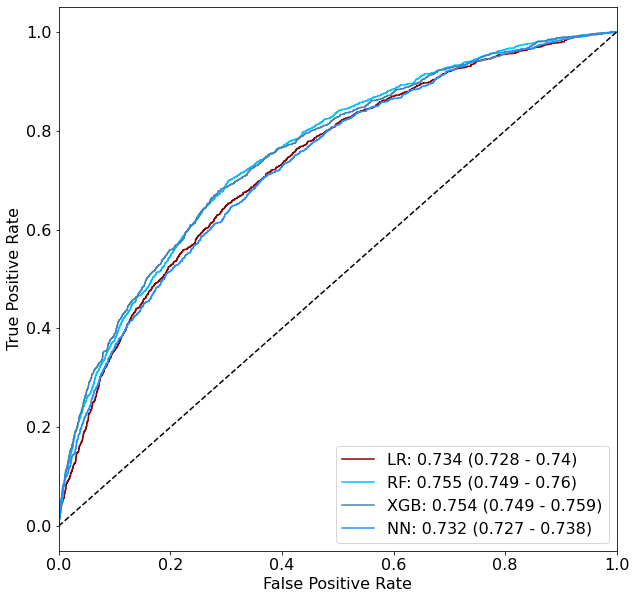

In [13]:

#create labels for roc curves
rf_label = 'RF: ' + str(round(rf_confidence[1], 3)) + ' (' + str(round(rf_confidence[0], 3)) + ' - ' + str(round(rf_confidence[2], 3)) + ')'
xgb_label = 'XGB: ' + str(round(xgb_confidence[1], 3)) + ' (' + str(round(xgb_confidence[0], 3)) + ' - ' + str(round(xgb_confidence[2], 3)) + ')'
nn_label = 'NN: ' + str(round(nn_confidence[1], 3)) + ' (' + str(round(nn_confidence[0], 3)) + ' - ' + str(round(nn_confidence[2], 3)) + ')'
lr_label = 'LR: ' + str(round(lr_confidence[1], 3)) + ' (' + str(round(lr_confidence[0], 3)) + ' - ' + str(round(lr_confidence[2], 3)) + ')'
#calculate tpr and fpr for each model
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_y_pred)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_y_pred)
nn_fpr, nn_tpr, _ = roc_curve(y_test, nn_y_pred)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_y_pred)

import matplotlib
matplotlib.rcParams.update({'font.size': 16})
#plot the ROC curves for each model
plt.figure(figsize=(10,10))
plt.plot(lr_fpr, lr_tpr, color='darkred', label=lr_label)
plt.plot(rf_fpr, rf_tpr, color='deepskyblue', label=rf_label)
plt.plot(xgb_fpr, xgb_tpr, color='steelblue', label=xgb_label)
plt.plot(nn_fpr, nn_tpr, color='dodgerblue', label=nn_label)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.savefig('results/os/roc.png', dpi=900, bbox_inches='tight')


In [16]:
plt.clf()


<Figure size 432x288 with 0 Axes>

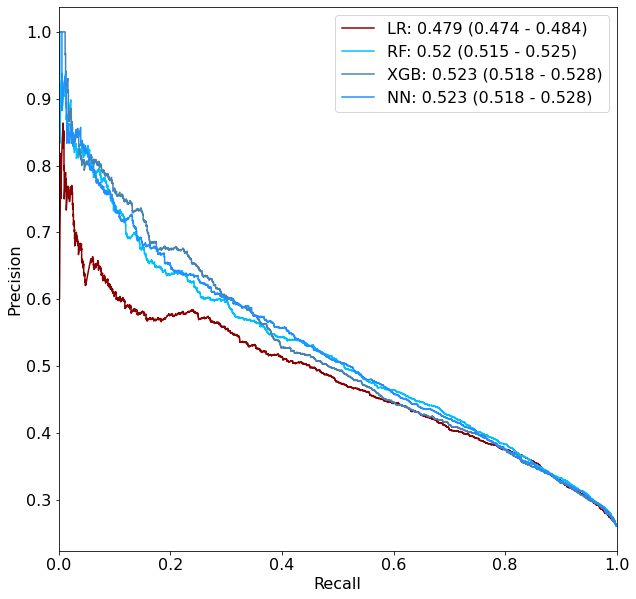

In [17]:

# %%
rf_auprc_ci = auprc_ci(y_test, rf_y_pred)
xgb_auprc_ci = auprc_ci(y_test, xgb_y_pred)
lr_auprc_ci = auprc_ci(y_test, lr_y_pred)
nn_auprc_ci = auprc_ci(y_test, nn_y_pred)
#calculate precision and recall for each model
rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_y_pred)
xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, xgb_y_pred)
nn_precision, nn_recall, _ = precision_recall_curve(y_test, nn_y_pred)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_y_pred)
#create labels for precision recall curves
rf_prc_label = 'RF: ' + str(round(rf_auprc_ci[1], 3)) + ' (' + str(round(rf_auprc_ci[0], 3)) + ' - ' + str(round(rf_auprc_ci[2], 3)) + ')'
xgb_prc_label = 'XGB: ' + str(round(xgb_auprc_ci[1], 3)) + ' (' + str(round(xgb_auprc_ci[0], 3)) + ' - ' + str(round(xgb_auprc_ci[2], 3)) + ')'
nn_prc_label = 'NN: ' + str(round(nn_auprc_ci[1], 3)) + ' (' + str(round(nn_auprc_ci[0], 3)) + ' - ' + str(round(nn_auprc_ci[2], 3)) + ')'
lr_prc_label = 'LR: ' + str(round(lr_auprc_ci[1], 3)) + ' (' + str(round(lr_auprc_ci[0], 3)) + ' - ' + str(round(lr_auprc_ci[2], 3)) + ')'
#plot the precision recall curves for each model
matplotlib.rcParams.update({'font.size': 16})
#plot the ROC curves for each model
plt.figure(figsize=(10,10))
plt.plot(lr_recall, lr_precision, color='darkred', label=lr_prc_label)
plt.plot(rf_recall, rf_precision, color='deepskyblue', label=rf_prc_label)
plt.plot(xgb_recall, xgb_precision, color='steelblue', label=xgb_prc_label)
plt.plot(nn_recall, nn_precision, color='dodgerblue', label=nn_prc_label)
plt.legend(loc="upper right")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.savefig('results/os/prc.png', dpi=900, bbox_inches='tight')


In [18]:
import shap
import seaborn as sns
from matplotlib import pyplot as plt

In [22]:
import shap
import seaborn as sns
from matplotlib import pyplot as plt

explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test.sample(n=500))
shap_obj = explainer(X_test.sample(n=500))
shap_df = pd.DataFrame(shap_values, columns=X_test.columns)

#get the mean absolute value for each feature
shap_mean = pd.DataFrame(shap_df.abs().mean(), columns=['importance'])
shap_mean.index.rename('feature', inplace=True)
shap_mean = shap_mean.sort_values('importance', ascending=False)
shap_mean.head()
shap_mean.to_csv('results/os/xgb_shap.csv')


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


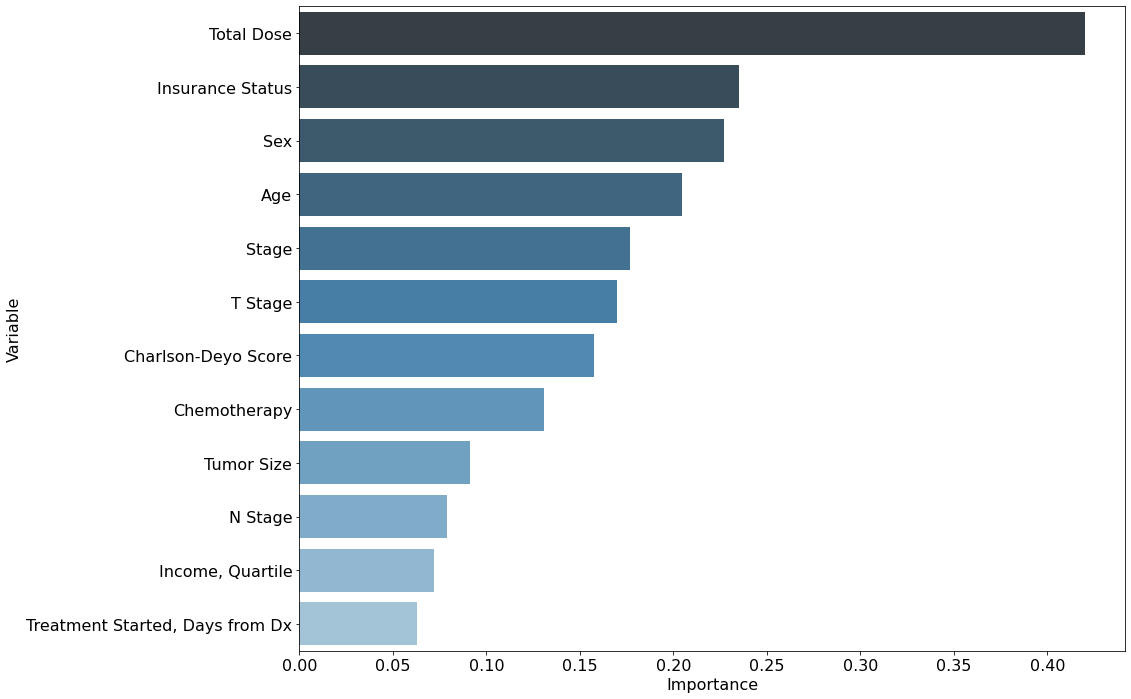

<Figure size 432x288 with 0 Axes>

In [23]:
import seaborn as sns
from matplotlib import pyplot as plt

fi = shap_mean.copy()
fi.head()

fi.reset_index(inplace=True)
fi.rename(columns={'feature':'Variable', 'importance':'Importance'}, inplace=True)
fi.loc[fi['Variable'] == 'stage', 'Variable'] = 'Stage'
fi.loc[fi['Variable'] == 't_stage', 'Variable'] = 'T Stage'
fi.loc[fi['Variable'] == 'Mucinous', 'Variable'] = 'Mucinous Histology'
fi.loc[fi['Variable'] == 'Systemic/Surgery Sequence', 'Variable'] = 'Neo-adjuvant Chemotherapy'
# fi = fi.loc[fi['Variable'] != 'CEA Interpretation']
# fi = fi.loc[fi['Variable'] != 'Metastatic Liver Involvement']
#makes the darkest blue at the top and lightest blue at the bottom
palette = sns.color_palette("Blues_d", n_colors=12)
palette.reverse()
#create a horizontal bar plot of the top 10 features
plt.figure(figsize=(16,10))
sns.barplot(x='Importance', y='Variable', data=fi.head(12), palette=palette)
#increase font size
plt.tight_layout()
plt.rcParams["font.size"] = 20
plt.show()
plt.savefig('results/os/xgb_shap.png')


In [24]:
from sklearn.metrics import recall_score, confusion_matrix
from imblearn.metrics import specificity_score
import numpy as np
thresh = np.arange(0, 1, 1e-3)
#create a dataframe to store the sensitivity and specificity at each threshold for each model
lr_senspec = pd.DataFrame(columns=['thresh', 'sens','spec','PPV','NPV'])
xgb_senspec = pd.DataFrame(columns=['thresh', 'sens','spec','PPV','NPV'])
lr_sens = {}
lr_spec = {}
lr_ppv = {}
lr_npv = {}
xgb_sens = {}
xgb_spec = {}
xgb_ppv = {}
xgb_npv = {}

for t in thresh:
    tn, fp, fn, tp = confusion_matrix(y_test, lr_y_pred > t).ravel()
    sen = (tp)/(tp+fn)
    sp = (tn)/(tn+fp)
    ppv = (tp)/(tp+fp)
    npv = (tn)/(tn+fn)

    lr_sens[t] = sen
    lr_spec[t] = sp
    lr_ppv[t] = ppv
    lr_npv[t] = npv

    tn, fp, fn, tp = confusion_matrix(y_test, xgb_y_pred > t).ravel()
    sen = (tp)/(tp+fn)
    sp = (tn)/(tn+fp)
    ppv = (tp)/(tp+fp)
    npv = (tn)/(tn+fn)

    xgb_sens[t] = sen
    xgb_spec[t] = sp
    xgb_ppv[t] = ppv
    xgb_npv[t] = npv
#add each dictionary to the dataframe
lr_senspec['thresh'] = lr_sens.keys()
lr_senspec['sens'] = lr_sens.values()
lr_senspec['spec'] = lr_spec.values()
lr_senspec['PPV'] = lr_ppv.values()
lr_senspec['NPV'] = lr_npv.values()
xgb_senspec['thresh'] = xgb_sens.keys()
xgb_senspec['sens'] = xgb_sens.values()
xgb_senspec['spec'] = xgb_spec.values()
xgb_senspec['PPV'] = xgb_ppv.values()
xgb_senspec['NPV'] = xgb_npv.values()
xgb_senatspec = {}
xgb_ppvatspec = {}
xgb_npvatspec = {}
lr_senatspec = {}
lr_ppvatspec = {}
lr_npvatspec = {}
#find the value for nn sensitivity where specificity is close to 90%
xgb_senatspec[90] = float(str(xgb_senspec['sens'].loc[round(xgb_senspec['spec'],2) == 0.900]).split()[1])
xgb_ppvatspec[90] = float(str(xgb_senspec['PPV'].loc[round(xgb_senspec['spec'],2) == 0.900]).split()[1])
xgb_npvatspec[90] = float(str(xgb_senspec['NPV'].loc[round(xgb_senspec['spec'],2) == 0.900]).split()[1])
lr_senatspec[90] = float(str(lr_senspec['sens'].loc[round(lr_senspec['spec'],2) == 0.900]).split()[1])
lr_ppvatspec[90] = float(str(lr_senspec['PPV'].loc[round(lr_senspec['spec'],2) == 0.900]).split()[1])
lr_npvatspec[90] = float(str(lr_senspec['NPV'].loc[round(lr_senspec['spec'],2) == 0.900]).split()[1])

xgb_senatspec[70] = float(str(xgb_senspec['sens'].loc[round(xgb_senspec['spec'],2) == 0.700]).split()[1])
xgb_ppvatspec[70] = float(str(xgb_senspec['PPV'].loc[round(xgb_senspec['spec'],2) == 0.700]).split()[1])
xgb_npvatspec[70] = float(str(xgb_senspec['NPV'].loc[round(xgb_senspec['spec'],2) == 0.700]).split()[1])
lr_senatspec[70] = float(str(lr_senspec['sens'].loc[round(lr_senspec['spec'],2) == 0.700]).split()[1])
lr_ppvatspec[70] = float(str(lr_senspec['PPV'].loc[round(lr_senspec['spec'],2) == 0.700]).split()[1])
lr_npvatspec[70] = float(str(lr_senspec['NPV'].loc[round(lr_senspec['spec'],2) == 0.700]).split()[1])

xgb_senatspec[50] = float(str(xgb_senspec['sens'].loc[round(xgb_senspec['spec'],2) == 0.500]).split()[1])
xgb_ppvatspec[50] = float(str(xgb_senspec['PPV'].loc[round(xgb_senspec['spec'],2) == 0.500]).split()[1])
xgb_npvatspec[50] = float(str(xgb_senspec['NPV'].loc[round(xgb_senspec['spec'],2) == 0.500]).split()[1])
lr_senatspec[50] = float(str(lr_senspec['sens'].loc[round(lr_senspec['spec'],2) == 0.500]).split()[1])
lr_ppvatspec[50] = float(str(lr_senspec['PPV'].loc[round(lr_senspec['spec'],2) == 0.500]).split()[1])
lr_npvatspec[50] = float(str(lr_senspec['NPV'].loc[round(lr_senspec['spec'],2) == 0.500]).split()[1])

xgb_senatspec[30] = float(str(xgb_senspec['sens'].loc[round(xgb_senspec['spec'],2) == 0.300]).split()[1])
xgb_ppvatspec[30] = float(str(xgb_senspec['PPV'].loc[round(xgb_senspec['spec'],2) == 0.300]).split()[1])
xgb_npvatspec[30] = float(str(xgb_senspec['NPV'].loc[round(xgb_senspec['spec'],2) == 0.300]).split()[1])
lr_senatspec[30] = float(str(lr_senspec['sens'].loc[round(lr_senspec['spec'],2) == 0.300]).split()[1])
lr_ppvatspec[30] = float(str(lr_senspec['PPV'].loc[round(lr_senspec['spec'],2) == 0.300]).split()[1])
lr_npvatspec[30] = float(str(lr_senspec['NPV'].loc[round(lr_senspec['spec'],2) == 0.300]).split()[1])

xgb_senatspec[10] = float(str(xgb_senspec['sens'].loc[round(xgb_senspec['spec'],2) == 0.100]).split()[1])
xgb_ppvatspec[10] = float(str(xgb_senspec['PPV'].loc[round(xgb_senspec['spec'],2) == 0.100]).split()[1])
xgb_npvatspec[10] = float(str(xgb_senspec['NPV'].loc[round(xgb_senspec['spec'],2) == 0.100]).split()[1])
lr_senatspec[10] = float(str(lr_senspec['sens'].loc[round(lr_senspec['spec'],2) == 0.100]).split()[1])
lr_ppvatspec[10] = float(str(lr_senspec['PPV'].loc[round(lr_senspec['spec'],2) == 0.100]).split()[1])
lr_npvatspec[10] = float(str(lr_senspec['NPV'].loc[round(lr_senspec['spec'],2) == 0.100]).split()[1])

#combine all the dictionaries into a dataframe
xgb_senatspec = pd.DataFrame.from_dict(xgb_senatspec, orient='index')
xgb_ppvatspec = pd.DataFrame.from_dict(xgb_ppvatspec, orient='index')
xgb_npvatspec = pd.DataFrame.from_dict(xgb_npvatspec, orient='index')
lr_senatspec = pd.DataFrame.from_dict(lr_senatspec, orient='index')
lr_ppvatspec = pd.DataFrame.from_dict(lr_ppvatspec, orient='index')
lr_npvatspec = pd.DataFrame.from_dict(lr_npvatspec, orient='index')

#rename the columns
xgb_senatspec.columns = ['xgb_sens']
xgb_ppvatspec.columns = ['xgb_ppv']
xgb_npvatspec.columns = ['xgb_npv']
lr_senatspec.columns = ['lr_sens']
lr_ppvatspec.columns = ['lr_ppv']
lr_npvatspec.columns = ['lr_npv']

#combine all the dataframes into one
senspec = pd.concat([xgb_senatspec, xgb_ppvatspec, xgb_npvatspec, lr_senatspec, lr_ppvatspec, lr_npvatspec], axis=1)
senspec.head()

invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_

,xgb_sens,xgb_ppv,xgb_npv,lr_sens,lr_ppv,lr_npv
90,0.373816,0.557055,0.802903,0.337999,0.533810,0.794084
70,0.647592,0.428260,0.849136,0.647592,0.428727,0.849243
50,0.820091,0.363437,0.886963,0.830383,0.366661,0.892876
30,0.922602,0.314836,0.915657,0.921779,0.314776,0.914951
10,0.987649,0.277085,0.956459,0.985179,0.276839,0.948791
